# Imports

In [48]:
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image, ImageDraw, ImageFont
import opencc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

# Load Raw Data

In [49]:
path = '/home/andrew/Picture-to-Pinyin'

# Import csv data
df = pd.read_csv(f'{path}/chinese_chars.csv')
df.sort_values(by=['stroke_count', 'pinyin'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,stroke_count,character,pinyin
0,1,一,yī
1,1,乙,yǐ
2,2,卜,bo
3,2,八,bā
4,2,匕,bǐ


# Create PNGs

In [50]:
# Creates a 'dim' * 'dim' PNG image out of 'char' and saves to 'file_path'
def create_PNG(char, file_path, dim=64):
    img = Image.new("L", (dim, dim), 255)
    draw = ImageDraw.Draw(img)

    font_path = f'{path}/font_huawenkaiti.ttf'
    font = font = ImageFont.truetype(font_path, size=dim*240//256)

    # Uses PIL to draw 'char' in the center
    text_bbox = draw.textbbox((0, 0), char, font)
    text_width = text_bbox[2] - text_bbox[0]
    text_x = (dim - text_width) // 2
    text_y = -dim*40//256
    draw.text((text_x, text_y), char, font=font, fill=0)
    
    img.save(file_path)
    
if not os.path.exists(f'{path}/char_dataset'):
    os.makedirs(f'{path}/char_dataset')

    # Loop through all chars in df
    for index, entry in df.iterrows():
        char = entry['character']
        traditional_char = opencc.OpenCC('s2t').convert(char)
        
        # Save only stroke_count, pinyin, and traditional_char for later use
        stroke_count = entry['stroke_count']
        pinyin = entry['pinyin']
        file_path = f'{path}/char_dataset/{index}_{stroke_count}_{traditional_char}_{pinyin}.png'
        create_PNG(traditional_char, file_path, 128)
        
        print(f"\rProcessed {index+1}/{df.shape[0]} characters", end='')

# Process Data / Create Labels

In [51]:
# Strips tone from syllable
tone_to_letter = {
    'ā': 'a', 'á': 'a', 'ǎ': 'a', 'à': 'a',
    'ē': 'e', 'é': 'e', 'ě': 'e', 'è': 'e',
    'ī': 'i', 'í': 'i', 'ǐ': 'i', 'ì': 'i',
    'ō': 'o', 'ó': 'o', 'ǒ': 'o', 'ò': 'o',
    'ū': 'u', 'ú': 'u', 'ǔ': 'u', 'ù': 'u',
    'ǖ': 'ü', 'ǘ': 'ü', 'ǚ': 'ü', 'ǜ': 'ü'
}

# Isolates tone from syllable
tone_to_number = {
    'ā': '1', 'á': '2', 'ǎ': '3', 'à': '4',
    'ē': '1', 'é': '2', 'ě': '3', 'è': '4',
    'ī': '1', 'í': '2', 'ǐ': '3', 'ì': '4',
    'ō': '1', 'ó': '2', 'ǒ': '3', 'ò': '4',
    'ū': '1', 'ú': '2', 'ǔ': '3', 'ù': '4',
    'ǖ': '1', 'ǘ': '2', 'ǚ': '3', 'ǜ': '4'
}

# Returns base syllable and tone number
def convert_pinyin(pinyin):
    base_syllable = ''
    tone_number = ''
    
    for char in pinyin:
        if char in tone_to_number:
            tone_number = tone_to_number[char]
            base_syllable += tone_to_letter[char]
        else:
            base_syllable += char
    
    return base_syllable, tone_number

# Returns index of file, used for sorting by stroke_count
def get_index(filename):
    return int(filename.split('_')[0])

# Loads processed images and creates labels
def load_data(image_folder):
    all_images = []
    all_labels = []
    filenames = sorted(os.listdir(image_folder), key=get_index)
    
    for filename in filenames:
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img / 255.0 # Normalize
        
        pinyin = filename.split('_')[-1].split('.')[0]
        pinyin_string, _ = convert_pinyin(pinyin) # Train model to identify pinyin without tone
        
        all_images.append(img)
        all_labels.append(pinyin_string)
            
    return np.array(all_images), np.array(all_labels)


def split_data(images, labels, val_split=0.2, test_split=0.2):
    size = len(images)
    val_end = int(size*(1-test_split))
    train_end = int(val_end*(1-val_split))
    
    train_images = images[:train_end]
    train_labels = labels[:train_end]
    val_images = images[train_end:val_end]
    val_labels = labels[train_end:val_end]
    test_images = images[val_end:]
    test_labels = labels[val_end:]
    
    return train_images, train_labels, val_images, val_labels, test_images, test_labels

In [52]:
images, labels = load_data(f'{path}/char_dataset')

# Encodes pinyin strings as integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

train_images, train_labels, val_images, val_labels, test_images, test_labels = split_data(images, labels)
print(f'Train: {train_images.shape[0]}\nVal: {val_images.shape[0]}\nTest: {test_images.shape[0]}')

Train: 7079
Val: 1770
Test: 2213


# Augment Data

In [53]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

if len(train_images.shape) == 3:
    train_images = np.expand_dims(train_images, axis=-1)

datagen.fit(train_images)
generator = datagen.flow(train_images, train_labels, batch_size=1)

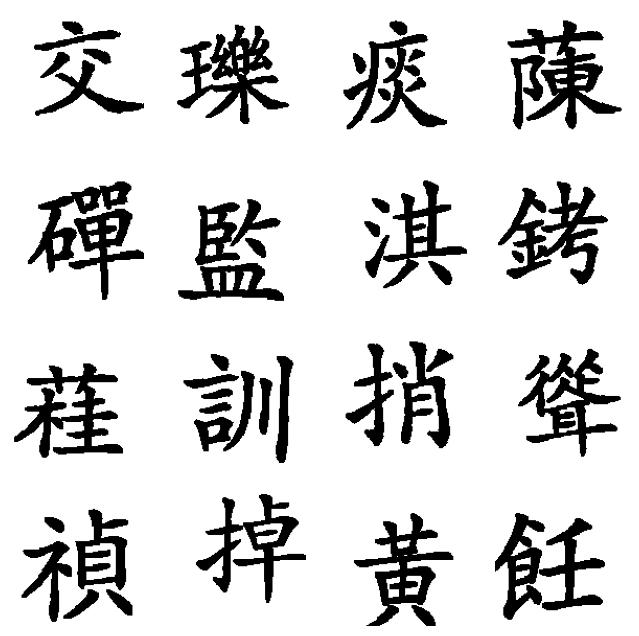

In [54]:
import matplotlib.pyplot as plt

num_images = 16
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()
for i in range(num_images):
    img = next(generator)[0].astype('uint8')
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()

# Train Model

/home/andrew/ITRI-LungCancer/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 753ms/step - accuracy: 0.0031 - loss: 7.1540 - val_accuracy: 0.0181 - val_loss: 5.9972
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.0046 - loss: 5.9849 - val_accuracy: 0.0130 - val_loss: 5.9969
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.0105 - loss: 5.9083 - val_accuracy: 0.0153 - val_loss: 5.9945
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.0149 - loss: 5.8399 - val_accuracy: 0.0124 - val_loss: 5.9927
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.0195 - loss: 5.7422 - val_accuracy: 0.0051 - val_loss: 5.9914
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.0290 - loss: 5.6480 - val_accuracy: 0.0051 - val_loss: 5.9913
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - accuracy: 0.0326 - loss: 5.5458 - val_accuracy: 0.0051 - val_loss: 5.9902
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.0466 - loss: 5.4367 - val_accuracy: 0.004

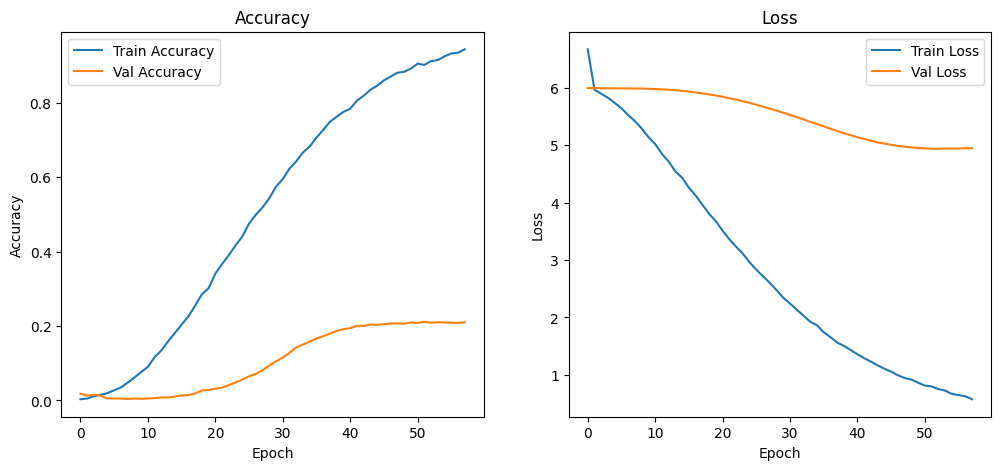

In [55]:
def create_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Third Convolutional Block
        # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Flatten and Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
    return model

input_shape = (128, 128, 1)
num_classes = len(np.unique(labels))
model = create_cnn_model(input_shape, num_classes)

history = model.fit(
    train_images, train_labels,
    # generator,
    epochs=200,
    batch_size=512,
    validation_data=(val_images, val_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate

In [56]:
accuracy = model.evaluate(val_images, val_labels, verbose=0)[1]
print(f'Test accuracy: {accuracy:.2f}')
loss = model.evaluate(val_images, val_labels, verbose=0)[0]
print(f'Test loss: {loss:.2f}')

Test accuracy: 0.21
Test loss: 4.94


In [57]:
model.save(f'{path}/model.keras')

In [58]:
def preprocess_image(image_path, target_size):
    # Load the image and resize it
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale')  # Adjust color_mode as needed
    img_array = image.img_to_array(img)
    
    # Normalize pixel values to [0, 1]
    img_array /= 255.0
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

image_path = '''
/home/andrew/Picture-to-Pinyin/char_dataset/9228_16_醒_xǐng.png
'''.strip()
input_shape = (128, 128)  # Adjust according to your model's input shape
processed_image = preprocess_image(image_path, target_size=input_shape)

# Make a prediction
model = tf.keras.models.load_model(f'{path}/model.keras')
predictions = model.predict(processed_image)

top_5_indices = np.argsort(predictions[0])[-5:][::-1]  # Indices of top 5 classes
top_5_probabilities = predictions[0][top_5_indices]
top_5_labels = [label_encoder.inverse_transform([i])[0] for i in top_5_indices]  # Convert indices to class labels

# Display results
for i in range(5):
    print(f"Class: {top_5_labels[i]}, Probability: {top_5_probabilities[i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Class: wu, Probability: 0.0525
Class: zi, Probability: 0.0231
Class: jia, Probability: 0.0226
Class: li, Probability: 0.0220
Class: tuo, Probability: 0.0206


Original image shape: (128, 128)
Reshaped pixels array shape: (16384, 1)
Labels array size: 16384


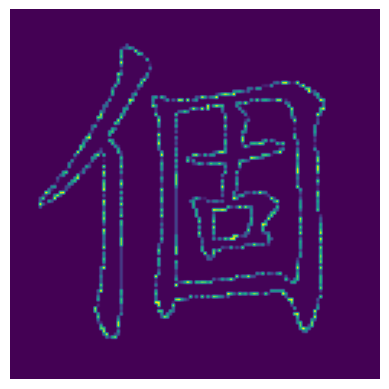

In [59]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt

# Load image using PIL and convert to numpy array
path = '/home/andrew/Picture-to-Pinyin/char_dataset/36_3_個_gè.png'
image = Image.open(path).convert('L')  # Convert image to grayscale
image = np.array(image)  # Convert image to numpy array

# Print the shape of the image to understand its dimensions
print("Original image shape:", image.shape)

# Normalize to [0, 1]
image = image / 255.0

# Reshape image to a 2D array of pixels
pixels = image.reshape(-1, 1)

# Print the shape of the reshaped pixels array
print("Reshaped pixels array shape:", pixels.shape)

# Standardize pixel values
scaler = StandardScaler()
pixels_scaled = scaler.fit_transform(pixels)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=100, random_state=0).fit(pixels_scaled)
labels = kmeans.labels_

# Print the size of the labels array
print("Labels array size:", labels.size)

# Reshape labels to the original image shape
clustered_image = labels.reshape(image.shape)

# Display the result
plt.imshow(clustered_image, cmap='viridis')
plt.axis('off')  # Optional: Turn off axis for better visualization
plt.show()